# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [1]:
# This data represents 17 campaigns that occurred between May 2008 and November 2010, corresponding to a total of 
# 79354 contacts.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [2]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import time
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_predict
import seaborn as sns
from scipy.stats import shapiro
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from mpl_toolkits.axes_grid1 import make_axes_locatable
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
import numpy as np
import matplotlib as mpl
from imblearn.under_sampling import RandomUnderSampler

In [3]:
df = pd.read_csv('/Users/chameleonjj/Downloads/module_17_starter/data/bank-additional-full.csv', sep = ';')

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [5]:
# Renaming target column 'y' to 'term_dep' to avoid the confusion
df.rename(columns={'y': 'term_dep'}, inplace=True)

In [6]:
# In the task 5 it is indicated that we will work on columns 1-7. Hence creating a dataframe with only these features
# and column 'term_dep' as a target.
df = df[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'term_dep']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        41188 non-null  int64 
 1   job        41188 non-null  object
 2   marital    41188 non-null  object
 3   education  41188 non-null  object
 4   default    41188 non-null  object
 5   housing    41188 non-null  object
 6   loan       41188 non-null  object
 7   term_dep   41188 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.5+ MB


In [7]:
# Understanding the values and checking for unusual values, typos... in column 'job'
df['job'].value_counts()

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

In [8]:
# Understanding the values and checking for unusual values, typos... in column 'marital'
df['marital'].value_counts()

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

In [9]:
# Understanding the values and checking for unusual values, typos... in column 'education'
df['education'].value_counts()

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

In [10]:
# Understanding the values and checking for unusual values, typos... in column 'default'
df['default'].value_counts()

no         32588
unknown     8597
yes            3
Name: default, dtype: int64

In [11]:
# Understanding the values and checking for unusual values, typos... in column 'housing'
df['housing'].value_counts()

yes        21576
no         18622
unknown      990
Name: housing, dtype: int64

In [12]:
# Understanding the values and checking for unusual values, typos... in column 'loan'
df['loan'].value_counts()

no         33950
yes         6248
unknown      990
Name: loan, dtype: int64

In [13]:
# Checking if there is any missing data
df.isna().any().any()

False

In [14]:
# Looks like no missing data. Now checking for anomaly values in the columns.
df['age'].value_counts()

31    1947
32    1846
33    1833
36    1780
35    1759
      ... 
89       2
91       2
94       1
87       1
95       1
Name: age, Length: 78, dtype: int64

In [15]:
# To open a bank account in Portugal, applicants must be aged at least 18.
# It is safe to assume that the life span runs through 99.
# I will check if any values are out of ordinary based on the above statements.
age_filter = (df['age'] < 18) | (df['age'] > 99)
df[age_filter]['age']

37140    17
37539    17
37558    17
37579    17
38274    17
Name: age, dtype: int64

In [16]:
# The 17 year old clients can't have a bank account and therefore I will delete rows (5) for these customers.
df = df[df['age'] != 17]

In [17]:
# Checking for anomaly values in the remaining columns.
df['default'].value_counts()

no         32583
unknown     8597
yes            3
Name: default, dtype: int64

In [18]:
# Out of remaining columns only 'default' column has a concerning data distribution. Since there are only 3
# (less than 0.008%) defults it doesn't make sense to keep this column. 
df.drop('default', axis=1, inplace=True)

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41183 entries, 0 to 41187
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        41183 non-null  int64 
 1   job        41183 non-null  object
 2   marital    41183 non-null  object
 3   education  41183 non-null  object
 4   housing    41183 non-null  object
 5   loan       41183 non-null  object
 6   term_dep   41183 non-null  object
dtypes: int64(1), object(6)
memory usage: 2.5+ MB


In [20]:
# The business objective is to predict if a bank client will sign up for a term deposit based on their information.
# The outcome helps the bank to make more informed decisions on marketing campaigns and to tailor their services to 
# better fit the clients' needs. This should ultimately lead to increased customer satisfaction, retention, and 
# improve bank profitability.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [21]:
# Using ordinal encoding for features 'housing' and 'loan'
encoder = OrdinalEncoder(categories=[['no', 'unknown', 'yes']] * 2)
df[['housing', 'loan']] = encoder.fit_transform(df[['housing', 'loan']])

In [22]:
# Using ordinal encoding for target feature
df['term_dep'] = df['term_dep'].map({'no': 0, 'yes': 1})

In [23]:
# Spliting the dataframe into the feature columns and the target column
X = df.drop('term_dep', axis=1)
y = df['term_dep']

0    36545
1     4638
Name: term_dep, dtype: int64


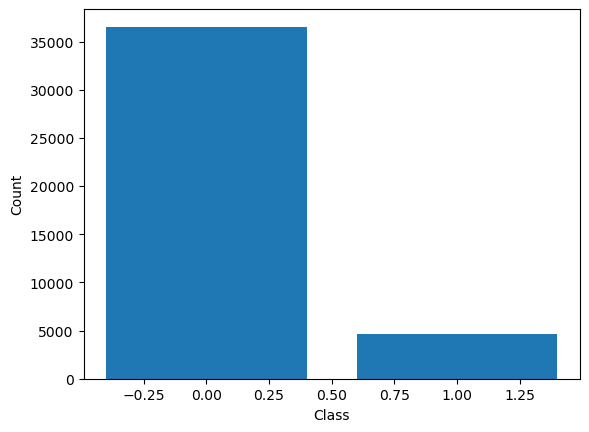

In [24]:
# Checking if the dataset is balanced
class_counts = df['term_dep'].value_counts()
print(class_counts)
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [25]:
# The data is imbalanced as we can see in the above chart. Imbalanced data can negatively impact the performance of 
# machine learning models, especialy if the minority class is of interest. Which in our case term deposit happens to 
# be the minority class. Therefore I will explore balancing the data to improve the performance of the models. I will 
# adjust the data set to be balanced with undersampling.

In [26]:
# Doing OHE
X = pd.get_dummies(X, columns=['job', 'marital', 'education'])

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [27]:
# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3
                                                    , random_state=42)

In [28]:
# StandardScaler works best with features that have a normal distribution.
# Using Shapiro-Wilk test if features have normal distribution.
for col in X.columns:
    stat, p = shapiro(X[col])
    alpha = 0.05
    if p > alpha:
        print(f'{col} is normally distributed (fail to reject H0)')
    else:
        print(f'{col} is not normally distributed (reject H0)')

age is not normally distributed (reject H0)
housing is not normally distributed (reject H0)
loan is not normally distributed (reject H0)
job_admin. is not normally distributed (reject H0)
job_blue-collar is not normally distributed (reject H0)
job_entrepreneur is not normally distributed (reject H0)
job_housemaid is not normally distributed (reject H0)
job_management is not normally distributed (reject H0)
job_retired is not normally distributed (reject H0)
job_self-employed is not normally distributed (reject H0)
job_services is not normally distributed (reject H0)
job_student is not normally distributed (reject H0)
job_technician is not normally distributed (reject H0)
job_unemployed is not normally distributed (reject H0)
job_unknown is not normally distributed (reject H0)
marital_divorced is not normally distributed (reject H0)
marital_married is not normally distributed (reject H0)
marital_single is not normally distributed (reject H0)
marital_unknown is not normally distributed (

/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41183 entries, 0 to 41187
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        41183 non-null  int64  
 1   job        41183 non-null  object 
 2   marital    41183 non-null  object 
 3   education  41183 non-null  object 
 4   housing    41183 non-null  float64
 5   loan       41183 non-null  float64
 6   term_dep   41183 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 2.5+ MB


In [30]:
# Creating an undersampler object
undersampler = RandomUnderSampler(random_state=42)

# Fitting and transforming the training data
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

In [31]:
# Now that the dataset is balanced I can scale the data

# Creating a StandardScaler object
scaler = StandardScaler()

# Fitting and transforming the training data
X_train_scaled = scaler.fit_transform(X_train_resampled)

# Transforming the test data using the scaler fitted on the training data
X_test_scaled = scaler.transform(X_test)


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [32]:
#Creating the baseline model
class_counts = df['term_dep'].value_counts()
majority_class = class_counts.idxmax()
y_baseline = np.full(df.shape[0], majority_class)
accuracy = accuracy_score(df['term_dep'], y_baseline)
print(f'The baseline performance that our classifier should aim to beat is accuracy of {accuracy}')

The baseline performance that our classifier should aim to beat is accuracy of 0.8873807153437098


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

### Problem 9: Score the Model

What is the accuracy of your model?

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

Classifier: Logistic Regression
Training time: 0.01s
Training accuracy: 0.5873
Testing accuracy: 0.6084
Cross-validation scores: [0.58256881 0.5970948  0.58333333 0.56422018 0.57874618]
Mean cross-validation accuracy: 0.5812
Standard deviation of cross-validation accuracy: 0.0105
Precision: 0.1526
Recall: 0.5570
F1 score: 0.2395
AUC: 0.5859

Classifier: KNN
Training time: 0.00s
Training accuracy: 0.6826
Testing accuracy: 0.6505
Cross-validation scores: [0.56422018 0.57262997 0.55963303 0.53440367 0.53975535]
Mean cross-validation accuracy: 0.5541
Standard deviation of cross-validation accuracy: 0.0146
Precision: 0.1466
Recall: 0.4474
F1 score: 0.2209
AUC: 0.5616

Classifier: Decision Tree
Training time: 0.01s
Training accuracy: 0.8271
Testing accuracy: 0.5930
Cross-validation scores: [0.54740061 0.55810398 0.50382263 0.54434251 0.5351682 ]
Mean cross-validation accuracy: 0.5378
Standard deviation of cross-validation accuracy: 0.0185
Precision: 0.1341
Recall: 0.4905
F1 score: 0.2107
AUC

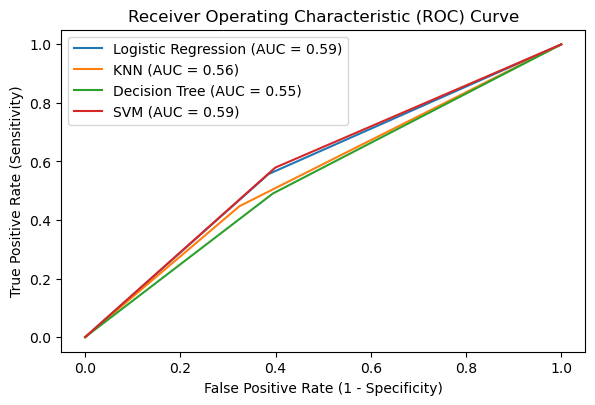

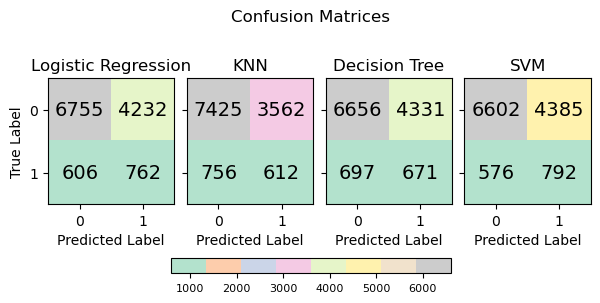

,Training time,Training accuracy,Testing accuracy
Logistic Regression,0.013286,0.587309,0.608418
KNN,0.000829,0.682569,0.650506
Decision Tree,0.013655,0.827064,0.593039
SVM,2.645369,0.620489,0.598462


In [33]:
# Initializing the classifiers
knn = KNeighborsClassifier()
logreg = LogisticRegression(max_iter=1000)
dt = DecisionTreeClassifier()
svm = SVC()

# Initializing dictionary to store confusion matrices
confusion_matrix_dict = {}

# Initializing an empty DataFrame to store the results
table = pd.DataFrame()

# Training and evaluating the classifiers
for clf, clf_name in [(logreg, 'Logistic Regression'), (knn, 'KNN'), (dt, 'Decision Tree'), (svm, 'SVM')]:
    start_time = time.time()
    clf.fit(X_train_scaled, y_train_resampled)
    end_time = time.time()
    training_time = end_time - start_time
    
    # Predicting using the trained classifier
    y_pred_train = clf.predict(X_train_scaled)
    training_accuracy = accuracy_score(y_train_resampled, y_pred_train)
    
    y_pred = clf.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=1)
    recall = recall_score(y_test, y_pred, zero_division=1)
    f1 = f1_score(y_test, y_pred, zero_division=1)
    auc_score = roc_auc_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    
    # Plotting ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {roc_auc:.2f})')
    
    # Storing confusion matrix in dictionary
    confusion_matrix_dict[clf_name] = confusion
    
    # Creating dictionary to hold results for this model
    results = {}
    results['Training time'] = training_time
    results['Training accuracy'] = training_accuracy
    results['Testing accuracy'] = accuracy
    
    # Adding results to table
    if clf_name == 'Logistic Regression':
        table = pd.DataFrame(results, index=[clf_name])
    else:
        table = pd.concat([table, pd.DataFrame(results, index=[clf_name])])


    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(clf, X_train_scaled, y_train_resampled, cv=cv, scoring='accuracy')
    print(f'Classifier: {clf_name}')
    print(f'Training time: {training_time:.2f}s')
    print(f'Training accuracy: {training_accuracy:.4f}')
    print(f'Testing accuracy: {accuracy:.4f}')
    print(f'Cross-validation scores: {cv_scores}')
    print(f'Mean cross-validation accuracy: {cv_scores.mean():.4f}')
    print(f'Standard deviation of cross-validation accuracy: {cv_scores.std():.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 score: {f1:.4f}')
    print(f'AUC: {auc_score:.4f}')
    print()
    
# Plotting ROC curves
plt.legend()
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.tight_layout()
plt.gcf().set_size_inches(6,4)
plt.show()


# Plotting confusion matrices
fig, axs = plt.subplots(1, 4, figsize=(7, 3), sharex=True, sharey=True)
fig.suptitle('Confusion Matrices')

for i, clf_name in enumerate(['Logistic Regression', 'KNN', 'Decision Tree', 'SVM']):
    confusion = confusion_matrix_dict[clf_name]
    im = axs[i].imshow(confusion, cmap='Pastel2', interpolation='None')
    axs[i].set_xticks([0, 1])
    axs[i].set_yticks([0, 1])
    axs[i].set_xlabel('Predicted Label')
    
    if i == 0:
        axs[i].set_ylabel('True Label')
    axs[i].set_title(f'{clf_name}')
    
    for j in range(2):
        for k in range(2):
            axs[i].text(k, j, str(confusion[j, k]), horizontalalignment='center', verticalalignment='center', fontsize=14)

# Adding colorbar under plot's title
fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.3, 0.1, 0.4, 0.05])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=8)

# Adjusting spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

table.head()


In [34]:
# SUMMARY: This approach returned results that have testing accuracy significantly worse (at least 26%) than the 
# baseline model. Eventhough the other metrics have improved compared to umbalanced data models they are still
# not good enough and that is why these models are not usable. 
# I will now run differnt parameters for the models to hopefully improve them.
# **************************
# **************************
# **************************

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

Classifier: Logistic Regression
Best hyperparameters: {'C': 0.1, 'penalty': 'l1'}
Training time: 2.65s
Training accuracy: 0.5881
Testing accuracy: 0.6119
Cross-validation scores: [0.58409786 0.58562691 0.56804281 0.57110092 0.57492355]
Mean cross-validation accuracy: 0.5768
Standard deviation of cross-validation accuracy: 0.0070
Precision: 0.1509
Recall: 0.5417
F1 score: 0.2361
AUC: 0.5812

Classifier: KNN
Best hyperparameters: {'n_neighbors': 7}
Training time: 2.65s
Training accuracy: 0.6702
Testing accuracy: 0.6391
Cross-validation scores: [0.58409786 0.58562691 0.56804281 0.57110092 0.57492355]
Mean cross-validation accuracy: 0.5768
Standard deviation of cross-validation accuracy: 0.0070
Precision: 0.1466
Recall: 0.4686
F1 score: 0.2233
AUC: 0.5644

Classifier: Decision Tree
Best hyperparameters: {'criterion': 'gini', 'max_depth': 5}
Training time: 2.65s
Training accuracy: 0.5919
Testing accuracy: 0.7093
Cross-validation scores: [0.58409786 0.58562691 0.56804281 0.57110092 0.5749235

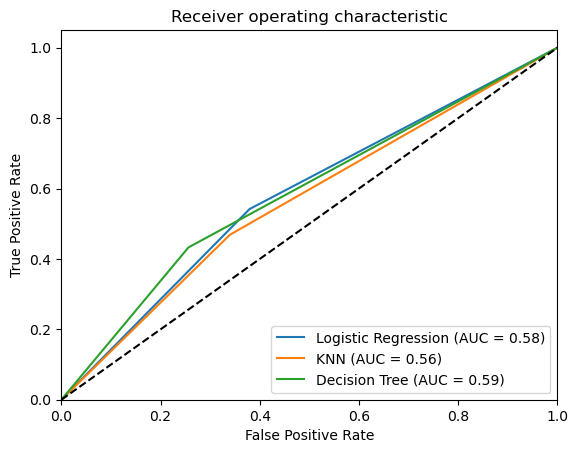

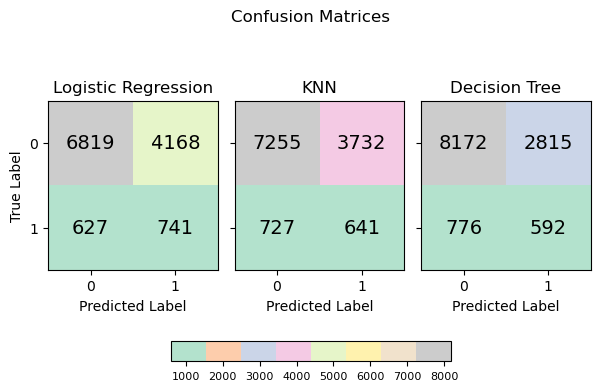

,Training time,Training accuracy,Testing accuracy
Logistic Regression,2.645369,0.588073,0.611898
KNN,2.645369,0.670183,0.639093
Decision Tree,2.645369,0.591896,0.709348


In [35]:
# Running 3 models (my machine is to slow to run SVM Model, I tried several times) and checking for best parameters.
# Initializing the classifiers with a range of hyperparameters
knn = KNeighborsClassifier()
logreg = LogisticRegression(max_iter=1000, solver='liblinear')
dt = DecisionTreeClassifier()

knn_param_grid = {'n_neighbors': [3, 5, 7]}
logreg_param_grid = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}
dt_param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 15]}

# Initializing dictionary to store confusion matrices
confusion_matrix_dict = {}

# Training and evaluating the classifiers
for clf, clf_name, param_grid in [(logreg, 'Logistic Regression', logreg_param_grid), 
                                  (knn, 'KNN', knn_param_grid), 
                                  (dt, 'Decision Tree', dt_param_grid)]:
    clf_gs = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')

    clf_gs.fit(X_train_scaled, y_train_resampled)
    
    # Predicting using the best hyperparameters
    clf = clf_gs.best_estimator_
    y_pred_train = clf.predict(X_train_scaled)
    training_accuracy = accuracy_score(y_train_resampled, y_pred_train)
    
    y_pred = clf.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=1)
    recall = recall_score(y_test, y_pred, zero_division=1)
    f1 = f1_score(y_test, y_pred, zero_division=1)
    auc_score = roc_auc_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    
    # Plotting ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {roc_auc:.2f})')
    
    # Storing confusion matrix in dictionary
    confusion_matrix_dict[clf_name] = confusion
    
    # Creating dictionary to hold results for this model
    results = {}
    results['Training time'] = training_time
    results['Training accuracy'] = training_accuracy
    results['Testing accuracy'] = accuracy
    
    # Adding results to table
    if clf_name == 'Logistic Regression':
        table = pd.DataFrame(results, index=[clf_name])
    else:
        table = pd.concat([table, pd.DataFrame(results, index=[clf_name])])

    # Printing best hyperparameters and performance metrics
    print(f'Classifier: {clf_name}')
    print(f'Best hyperparameters: {clf_gs.best_params_}')
    print(f'Training time: {training_time:.2f}s')
    print(f'Training accuracy: {training_accuracy:.4f}')
    print(f'Testing accuracy: {accuracy:.4f}')
    print(f'Cross-validation scores: {cv_scores}')
    print(f'Mean cross-validation accuracy: {cv_scores.mean():.4f}')
    print(f'Standard deviation of cross-validation accuracy: {cv_scores.std():.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 score: {f1:.4f}')
    print(f'AUC: {auc_score:.4f}')
    print()
    
# Plotting ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right')

# Plotting confusion matrices
fig, axs = plt.subplots(1, 3, figsize=(7, 4), sharex=True, sharey=True)
fig.suptitle('Confusion Matrices')

for i, clf_name in enumerate(['Logistic Regression', 'KNN', 'Decision Tree']):
    confusion = confusion_matrix_dict[clf_name]
    im = axs[i].imshow(confusion, cmap='Pastel2', interpolation='None')
    axs[i].set_xticks([0, 1])
    axs[i].set_yticks([0, 1])
    axs[i].set_xlabel('Predicted Label')
    
    if i == 0:
        axs[i].set_ylabel('True Label')
    axs[i].set_title(f'{clf_name}')
    
    for j in range(2):
        for k in range(2):
            axs[i].text(k, j, str(confusion[j, k]), horizontalalignment='center', verticalalignment='center', fontsize=14)

# Adding colorbar under plot's title
fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.3, 0.1, 0.4, 0.05])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=8)

# Adjusting spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

#Printing table of results
table.head()

In [ ]:
# SUMMARY: This approach returned results that have testing accuracy significantly worse (at least 20%) than the 
# baseline model. Eventhough some of the other metrics have improved compared to umbalanced data models they are still
# not good enough and that is why these models are not usable. 
# **************************
# **************************
# **************************